In [1]:
import networkx as nx
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

import numpy as np
import pandas as pd
from collections import Counter
import itertools

from math import comb, ceil
import random
import string

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
def init_association_matrix(belief_network, propositions = ['A','B','C','D']):
    
    propositions_w_sign = ["+"+p for p in propositions] + ["-"+p for p in propositions] # add the signs

    propositions_w_sign = sorted(propositions_w_sign, key=lambda x: x[1]) # sort by proposition, not sign

    association_matrix = pd.DataFrame(index=propositions_w_sign,  # create the association matrix
                                      columns=propositions_w_sign).fillna(0)

    for e in belief_network.edges(): # fill up 
        for s in [*itertools.product(['+','-'],['+','-'])]:
            association_matrix[f'{s[0]}{e[0]}'][f'{s[1]}{e[1]}'] = 1
            association_matrix[f'{s[0]}{e[1]}'][f'{s[1]}{e[0]}'] = 1

    return association_matrix

In [3]:
def init_beliefs(propositions):
    
    beliefs = np.random.uniform(-1, 1, size=len(propositions))
    beliefs = {e:b for e,b in zip(sorted(propositions), beliefs)}
    
    return beliefs

In [4]:
def bayesian(e1, e2, association_matrix):
    
    evidence = association_matrix[f'-{e2[1]}'].sum() + association_matrix[f'+{e2[1]}'].sum()
    joint_1 = association_matrix[f'+{e2[1]}'][f'+{e1[1]}'] + association_matrix[f'-{e2[1]}'][f'-{e1[1]}']
    joint_2 = association_matrix[f'-{e2[1]}'][f'+{e1[1]}'] + association_matrix[f'+{e2[1]}'][f'-{e1[1]}']
    
    likelihood_pos_rel = joint_1/evidence
    likelihood_neg_rel = joint_2/evidence
    
    return likelihood_pos_rel, likelihood_neg_rel

In [5]:
def infer_relationship(message_to_convey, association_matrix):
    
    e1 = message_to_convey['e1']
    e2 = message_to_convey['e2']
    
    likelihood_pos_rel, likelihood_neg_rel = bayesian(e1, e2, association_matrix)
    
    if likelihood_pos_rel > likelihood_neg_rel:
        return 1
    else:
        return -1

In [6]:
def energy(message_to_convey, beliefs, relationship):
    
    e1 = message_to_convey['e1']
    e2 = message_to_convey['e2']
    
    return - beliefs[e1[1]]*beliefs[e2[1]]*relationship

In [7]:
def energy_comprehensive(message_to_convey, beliefs, association_matrix, belief_network):
    
    energy_sum = 0

    e2 = message_to_convey['e2']
    neighbors = [*belief_network.neighbors(e2[1])]

    for e1 in neighbors:

        message_to_convey = {'e1':f"+{e1}", 'e2':e2}

        relationship = infer_relationship(message_to_convey = message_to_convey, 
                                          association_matrix = association_matrix)

        e = energy(message_to_convey = message_to_convey, beliefs = beliefs, relationship = relationship)

        denominator = association_matrix[f"-{e2[1]}"].sum() + association_matrix[f"+{e2[1]}"].sum()
        nominator = association_matrix[f"-{e2[1]}"][f"-{e1}"].sum() + association_matrix[f"+{e2[1]}"][f"-{e1}"].sum() + association_matrix[f"-{e2[1]}"][f"+{e1}"].sum() + association_matrix[f"+{e2[1]}"][f"+{e1}"].sum()
        weight = nominator / denominator

        energy_sum += e * weight

    return energy_sum

In [8]:
def update_belief(e1, beliefs):
    
    update_term = np.random.normal() # get an update term randomly
    
    beliefs_new = beliefs.copy() # make a copy of beliefs
    
    beliefs_new[e1[1]] = beliefs_new[e1[1]] + update_term # update the belief
    
    if beliefs_new[e1[1]] > 1:
        beliefs_new[e1[1]] = 1
        
    if beliefs_new[e1[1]] < -1:
        beliefs_new[e1[1]] = -1
    
    return beliefs_new

In [9]:
def update_association_matrix(message_to_convey, association_matrix):
    
    e1 = message_to_convey['e1']
    e2 = message_to_convey['e2']
    
    association_matrix[e2][e1] += 1
    association_matrix[e1][e2] += 1

In [10]:
def init_agents(belief_network, propositions, n_agents = 2):
    
    agents = {}
    
    for a in range(n_agents):
        agents[a] = {}
        agents[a]['association_matrix'] = init_association_matrix(belief_network, propositions)
        agents[a]['beliefs'] = init_beliefs(propositions)
    
    return agents

In [11]:
def deduce_message_to_convey(beliefs_to_convey, agent_beliefs):
    
    message_to_convey = {}
    
    for i, b in enumerate(beliefs_to_convey):
        if np.sign(agent_beliefs[beliefs_to_convey[i]]) == -1:
            message_to_convey[f"e{i+1}"] = f"-{beliefs_to_convey[i]}"
        else:
            message_to_convey[f"e{i+1}"] = f"+{beliefs_to_convey[i]}"
    
    return message_to_convey

In [408]:
def optimal_clustering(beliefs, n_agents):
    
    silhouettes = []
    n_clusters = [*range(2,n_agents)]

    for k in n_clusters:
        clustering = KMeans(n_clusters=k).fit(beliefs)
        silhouettes.append(silhouette_score(beliefs, clustering.labels_))
    
    return n_clusters[np.argmax(silhouettes)], silhouettes[np.argmax(silhouettes)]

def evaluatory_agreement(beliefs):
    
    pref_corr = pd.DataFrame(beliefs).T.corr()
    pref_corr = pref_corr.to_numpy()
    pref_corr = pref_corr[np.triu_indices_from(pref_corr, k=1)]
    
    return pref_corr

def interpretative_agreement(propositions, agents):
    
    proposition_combinations = [*itertools.combinations(propositions, 2)]

    posteriors_all = []
    for matrix in [v['association_matrix'] for v in agents.values()]:
        posteriors = []
        for p1, p2 in proposition_combinations:
            posterior_pos, posterior_neg = bayesian(f'+{p1}', f'+{p2}', matrix)
            posteriors.append(posterior_pos)
            posteriors.append(posterior_neg)

        posteriors_all.append(posteriors)

    interpretative_dist = pairwise_distances(np.array(posteriors_all),metric='euclidean')

    interpretative_dist = interpretative_dist[np.triu_indices_from(interpretative_dist, k=1)]
    
    return interpretative_dist

# Simulation of 2 Agents

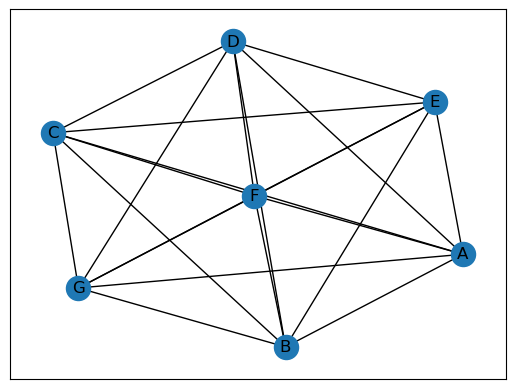

In [61]:
n_beliefs = 7
m = comb(n_beliefs,2)

is_connected = False # initialize the belief network
while is_connected == False:
    bn1 = nx.gnm_random_graph(n=n_beliefs, m = m)
    if nx.number_of_selfloops(bn1) == 0:
        is_connected = nx.is_connected(bn1)

propositions = list(string.ascii_uppercase[:n_beliefs]) # get the proposition names from the alphabet

bn1 = nx.relabel_nodes(bn1, {n:propositions[n] for n in bn1.nodes()}) # relabel the nodes with letters from the alphabet

nx.draw_networkx(bn1) # draw the belief network

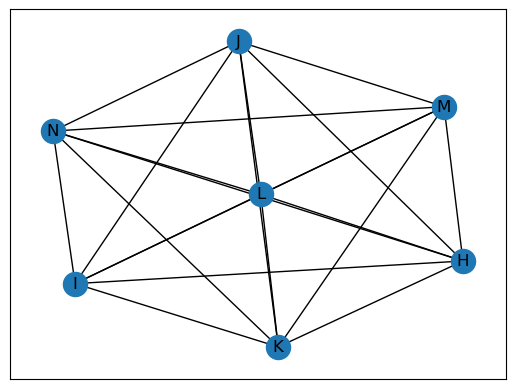

In [62]:
bn2 = bn1.copy()
bn2 = nx.relabel_nodes(bn2,{l1:l2 for l1,l2 in zip([*bn1.nodes],string.ascii_uppercase[len(bn1):len(bn1)+len(bn2)])})
nx.draw_networkx(bn2)

#### Compose networks

In [113]:
n_nodes_to_connect = 2
edges_to_add = []

for c in range(n_nodes_to_connect):
    pair_exists = True
    while pair_exists:
        pair = (np.random.choice([*bn1.nodes()]), np.random.choice([*bn2.nodes()]))
        if pair not in edges_to_add:
            pair_exists = False

    edges_to_add.append(pair)

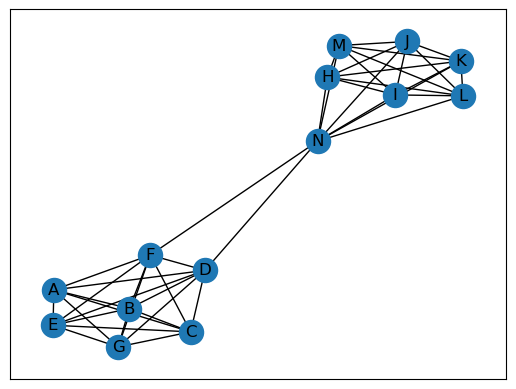

In [114]:
bn_composed = nx.compose(bn1,bn2)
propositions = [*bn_composed.nodes()]

for edge in edges_to_add:
    bn_composed.add_edge(edge[0], edge[1])

nx.draw_networkx(bn_composed)

In [115]:
n_agents = 2

agents = init_agents(bn_composed, propositions, n_agents)

simulation_steps = [*range(5000)]

for t in simulation_steps:
    
    i = np.random.choice([0,1]) # choose an agent to be the sender
    j = list(set([0,1]) - set([i]))[0] # the other one will be the receiver
    
    b1 = np.random.choice([*bn_composed.nodes()])
    b2 = np.random.choice([*bn_composed.neighbors(b1)])
    beliefs_to_convey = [b1,b2]
    
    message_to_convey = deduce_message_to_convey(beliefs_to_convey, agents[i]['beliefs']) # deduce the message to convey
    update_association_matrix(message_to_convey, agents[j]['association_matrix']) # update receiver's association matrix
    
    relationship = infer_relationship(message_to_convey, association_matrix=agents[j]['association_matrix'])
    
    beliefs_new = update_belief(message_to_convey['e1'], agents[j]['beliefs'])
    
    energy_t = energy_comprehensive(message_to_convey = message_to_convey,
                                     beliefs = agents[j]['beliefs'], 
                                     association_matrix = agents[j]['association_matrix'],
                                     belief_network = bn_composed)
    
    energy_t_plus_1 = energy_comprehensive(message_to_convey = message_to_convey,
                                     beliefs = beliefs_new, 
                                     association_matrix = agents[j]['association_matrix'],
                                     belief_network = bn_composed)
    
    if energy_t_plus_1 < energy_t:
        agents[j]['beliefs'] = beliefs_new

In [191]:
((agents[0]['association_matrix']['+F']['+B'].sum()+agents[0]['association_matrix']['-F']['+B'].sum()) + (agents[0]['association_matrix']['+F']['-B'].sum()+agents[0]['association_matrix']['-F']['-B'].sum())) / (agents[0]['association_matrix']['+F'].sum()+agents[0]['association_matrix']['-F'].sum())


0.23414634146341465

In [171]:
message_to_convey = {'e1': '+B', 'e2': '+C'}

energy_comprehensive(message_to_convey = message_to_convey,
                     beliefs = agents[0]['beliefs'], 
                     association_matrix = agents[1]['association_matrix'],
                     belief_network = bn1)

+C
['A', 'F']
A 0.4728682170542636
F 0.5271317829457365


-1.0

In [173]:
[*bn1.neighbors('C')]

['A', 'F']

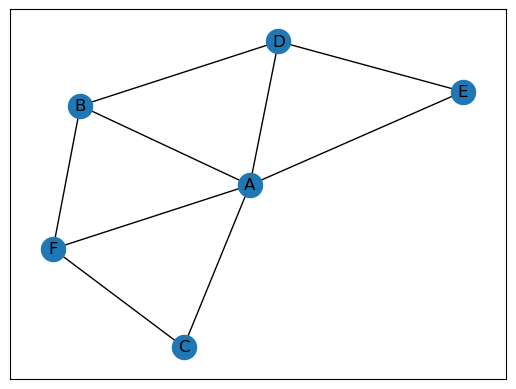

In [166]:
nx.draw_networkx(bn1)

# Simulation of Multiple Agents

In [406]:
n_agents = 20

agents = init_agents(bn_composed, propositions, n_agents)
agent_list = [*agents.keys()]
node_list = [*bn_composed.nodes()]

simulation_steps = [*range(501)]

track = {}

for t in tqdm(simulation_steps):
    
    i,j = np.random.choice(agent_list,2,replace=False) # choose an agent to be the sender and the other one will be the receiver
    
    b1 = np.random.choice(node_list)
    b2 = np.random.choice([*bn_composed.neighbors(b1)])
    beliefs_to_convey = [b1,b2]
    
    message_to_convey = deduce_message_to_convey(beliefs_to_convey, agents[i]['beliefs']) # deduce the message to convey
    update_association_matrix(message_to_convey, agents[j]['association_matrix']) # update receiver's association matrix
    
    relationship = infer_relationship(message_to_convey, association_matrix=agents[j]['association_matrix'])
    
    beliefs_new = update_belief(message_to_convey['e1'], agents[j]['beliefs'])
    
    energy_t = energy_comprehensive(message_to_convey = message_to_convey,
                                     beliefs = agents[j]['beliefs'], 
                                     association_matrix = agents[j]['association_matrix'],
                                     belief_network = bn_composed)
    
    energy_t_plus_1 = energy_comprehensive(message_to_convey = message_to_convey,
                                     beliefs = beliefs_new, 
                                     association_matrix = agents[j]['association_matrix'],
                                     belief_network = bn_composed)
    
    if t % 100 == 0:
        track[t] = {}
        
        beliefs = np.array([[*a['beliefs'].values()] for a in agents.values()])
        
        # Count of unique belief networks
        unique_belief_networks = np.unique(beliefs,axis=0)
        track[t]['count_unique_belief_networks'] = len(unique_belief_networks)
        
        # Number of clusters
        cluster_count, silhouette = optimal_clustering(beliefs, n_agents)
        track[t]['cluster_count'] = cluster_count
        track[t]['silhouette_score'] = silhouette
        
        # Preference congruence and similarity
        pref_corr = evaluatory_agreement(beliefs)
        track[t]['preference_congruence'] = pref_corr.mean()
        track[t]['preference_similarity'] = np.abs(pref_corr).mean()
        
        # Computing evaluatory agreement
        interpretative_dist = interpretative_agreement(propositions, agents)
        track[t]['evaluatory_agreement'] = np.mean(interpretative_dist)

        # Stop if everybody has either -1 or +1 only
        if len(np.unique(unique_belief_networks))==2:
            break

    if energy_t_plus_1 < energy_t:
        agents[j]['beliefs'] = beliefs_new

  0%|                                                                                                                                                                               | 0/501 [00:00<?, ?it/s]/Users/oseckin/miniconda3/envs/opinion_dynamics/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/oseckin/miniconda3/envs/opinion_dynamics/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/oseckin/miniconda3/envs/opinion_dynamics/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  w

/Users/oseckin/miniconda3/envs/opinion_dynamics/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/oseckin/miniconda3/envs/opinion_dynamics/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/oseckin/miniconda3/envs/opinion_dynamics/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/oseckin/miniconda3/envs/opinion_dynamics/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4

In [398]:
interpretative_dist

array([0.13698778, 0.1543576 , 0.1375906 , 0.14413184, 0.15033981,
       0.14746912, 0.14551446, 0.15409278, 0.1449944 , 0.16622281,
       0.16251486, 0.14762131, 0.14830695, 0.15796349, 0.15007313,
       0.15507962, 0.15065959, 0.16297321, 0.13143199, 0.16624485,
       0.14693004, 0.14740605, 0.13226391, 0.1502528 , 0.16246847,
       0.14871691, 0.1456154 , 0.13850181, 0.15409427, 0.1625979 ,
       0.14340562, 0.14338084, 0.15214057, 0.1324118 , 0.1359583 ,
       0.15224765, 0.15702254, 0.16400314, 0.15918032, 0.15319301,
       0.14973078, 0.15700286, 0.14407353, 0.14508186, 0.14579018,
       0.13534244, 0.1467401 , 0.16273564, 0.15266717, 0.15127117,
       0.15312416, 0.15035279, 0.15027993, 0.1519253 , 0.14507812,
       0.15234135, 0.13877316, 0.14751751, 0.14666991, 0.17417396,
       0.15149623, 0.14535953, 0.16188415, 0.15398894, 0.16206097,
       0.16582794, 0.16712614, 0.16008334, 0.17116164, 0.15286091,
       0.15284108, 0.15273397, 0.16051177, 0.15019178, 0.16722

In [308]:
agents[0]['association_matrix'][f"-{p1}"][f"+{p2}"].sum()/agents[0]['association_matrix'][f"-{p1}"].sum() + agents[0]['association_matrix'][f"+{p1}"][f"-{p2}"].sum()/agents[0]['association_matrix'][f"+{p1}"].sum()

0.20012481797378823

In [298]:
agents[0]['association_matrix'][f"+{p1}"][f"+{p2}"].sum()/agents[0]['association_matrix'][f"+{p1}"].sum()

'A'

In [299]:
p1

'N'